In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import holidays
# For evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# SARIMAX from statsmodels (ensure you have statsmodels installed)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Deep Learning and Hyperparameter Tuning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# For scaling residuals before training LSTM
from sklearn.preprocessing import StandardScaler

In [ ]:
# Simulated dataset
# def load_data():
#     # Simulated dataset (replace with your real data)
#     np.random.seed(42)
#     dates = pd.date_range(start="2022-01-01", periods=730)
#     # Create bursty high-fluctuation data
#     cpu_usage = []
#     current = 200

#     for _ in range(len(dates)):
#         spike = np.random.randint(-100, 100)
#         current = max(0, current + spike + np.random.normal(0, 15))
#         cpu_usage.append(current)
    
#     # cpu_usage = np.random.normal(loc=50, scale=10, size=len(dates)) + 10 * np.sin(np.linspace(0, 3 * np.pi, len(dates)))

#     df = pd.DataFrame({
#         'date': dates,
#         'namespace': ['default'] * len(dates),
#         'cpu_used': cpu_usage
#     })
#     df.set_index('date', inplace=True)
#     return df
# df = load_data()
# df.to_csv("../data/cpu_usage.csv")

In [ ]:

# ########################################
# # 1. DATA PREPARATION & FEATURE ENGINEERING
# ########################################

# # Load the dataset (assumes a CSV file with columns: date, namespace, cpu used)
# df = pd.read_csv('cpu_usage.csv', parse_dates=['date'])

# # For this example, filter the data for one namespace if necessary
# namespace_of_interest = 'default'  # adjust as needed
# df = df[df['namespace'] == namespace_of_interest].copy()

# # Sort by date and set the index
# df.sort_values('date', inplace=True)
# df.set_index('date', inplace=True)

# # ----------------------------
# # Feature: US Holiday Indicator
# # ----------------------------
# # Using the 'holidays' package, flag each date if it is a US holiday.
# us_holidays = holidays.UnitedStates()
# df['is_holiday'] = df.index.to_series().apply(lambda d: 1 if d in us_holidays else 0)

# # ----------------------------
# # Additional Feature (Optional): 7-Day Rolling Average
# # ----------------------------
# # We use a 7-day rolling average (shifted to ensure only past information is used)
# df['cpu_roll_mean_7'] = df['cpu_used'].rolling(window=7, min_periods=1).mean().shift(1)
# df['cpu_roll_mean_7'].fillna(method='bfill', inplace=True)

# # For the SARIMAX model we will use the holiday indicator and the rolling average as exogenous regressors.
# exog_columns = ['is_holiday', 'cpu_roll_mean_7']
# exog = df[exog_columns]
# y_series = df['cpu_used']

# ########################################
# # 2. SPLIT DATA INTO TRAIN AND TEST
# ########################################

# # Let’s use an 80% training split (by time)
# split_idx = int(len(df) * 0.8)
# y_train = y_series.iloc[:split_idx]
# y_test = y_series.iloc[split_idx:]
# exog_train = exog.iloc[:split_idx]
# exog_test = exog.iloc[split_idx:]

# ########################################
# # 3. BUILD THE SARIMAX MODEL (LINEAR COMPONENT)
# ########################################

# # Here, we choose a basic order. In practice, you might want to grid search orders.
# sarimax_order = (1, 1, 1)
# # We disable strict stationarity/invertibility enforcement for flexibility.
# sarimax_model = SARIMAX(y_train, exog=exog_train, order=sarimax_order,
#                         enforce_stationarity=False, enforce_invertibility=False)
# sarimax_result = sarimax_model.fit(disp=False)
# print("SARIMAX model summary:")
# print(sarimax_result.summary())

# # In-sample forecast (fitted values) for training period:
# train_pred_sarimax = sarimax_result.fittedvalues

# # Forecast for the test period (or for future dates) using future values of the exogenous variables:
# test_forecast_sarimax = sarimax_result.get_forecast(steps=len(y_test), exog=exog_test).predicted_mean

# # Compute residuals on the training set: what SARIMAX did not capture.
# residual_train = y_train - train_pred_sarimax

# ########################################
# # 4. PREPARE DATA FOR THE LSTM MODEL (NONLINEAR RESIDUALS)
# ########################################

# # We now model the residuals with an LSTM. We combine:
# #  - The scaled residual (our target)
# #  - The US holiday flag (since nonlinear behavior may be linked to holidays)
# #
# # First, scale the residuals. We use StandardScaler since residuals are typically near zero.
# scaler_res = StandardScaler()
# res_train_scaled = scaler_res.fit_transform(residual_train.values.reshape(-1, 1))
# # Extract the corresponding holiday indicator (unaltered, as it is binary)
# holiday_train = exog_train['is_holiday'].values.reshape(-1, 1)

# # Concatenate these two as columns; each row is: [scaled_residual, holiday_indicator]
# lstm_train_data = np.hstack((res_train_scaled, holiday_train))

# # Define a helper to create sequences from multivariate time series data.
# def create_sequences_lstm(data, look_back=14, target_idx=0):
#     """
#     data: numpy array of shape (samples, features)
#     look_back: number of previous time steps to use for prediction
#     target_idx: the column index of the target in data (here, residual value is at col 0)
#     """
#     X, y = [], []
#     for i in range(look_back, len(data)):
#         X.append(data[i-look_back:i, :])
#         y.append(data[i, target_idx])
#     return np.array(X), np.array(y)

# look_back = 14  # Number of past days used for prediction (you can fine-tune this)
# X_lstm, y_lstm = create_sequences_lstm(lstm_train_data, look_back=look_back, target_idx=0)
# print("LSTM training data shape:", X_lstm.shape)

# ########################################
# # 5. TUNE THE LSTM NETWORK USING KERAS TUNER
# ########################################

# def build_model(hp):
#     model = Sequential()
#     # First LSTM layer: search for number of units between 32 and 128 in steps of 32.
#     model.add(LSTM(
#         units=hp.Int('units', min_value=32, max_value=128, step=32),
#         return_sequences=True,
#         input_shape=(X_lstm.shape[1], X_lstm.shape[2])
#     ))
#     # Dropout rate between 0.0 and 0.5.
#     model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
#     # Second LSTM layer: search for number of units between 16 and 64.
#     model.add(LSTM(units=hp.Int('units_2', min_value=16, max_value=64, step=16)))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mse')
#     return model

# # Use Keras Tuner to search over the defined space.
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=2,
#     directory='lstm_tuner_dir',
#     project_name='residual_forecast'
# )

# # Use 80-20 split from the available training sequences for tuning.
# split_tuner = int(0.8 * X_lstm.shape[0])
# X_tuner_train, X_tuner_val = X_lstm[:split_tuner], X_lstm[split_tuner:]
# y_tuner_train, y_tuner_val = y_lstm[:split_tuner], y_lstm[split_tuner:]

# tuner.search(X_tuner_train, y_tuner_train, epochs=50, validation_data=(X_tuner_val, y_tuner_val), verbose=1)
# best_model = tuner.get_best_models(num_models=1)[0]
# print("Best LSTM hyperparameters:")
# print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

# # Train the chosen model further on all training sequences (using early stopping)
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# history_residual = best_model.fit(X_lstm, y_lstm, epochs=50, batch_size=16, validation_split=0.2,
#                                   callbacks=[early_stop], verbose=1)

# ########################################
# # 6. FORECASTING THE NEXT 30 DAYS WITH THE HYBRID MODEL
# ########################################

# forecast_horizon = 30

# # ---------- SARIMAX Forecast ----------
# # Prepare future exogenous regressors. For each future date, we must generate:
# #   - is_holiday: using the US holiday calendar
# #   - cpu_roll_mean_7: here we make a simple assumption by carrying forward the last known value.
# last_date = df.index[-1]
# future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_horizon)
# future_exog = pd.DataFrame(index=future_dates)
# future_exog['is_holiday'] = future_exog.index.to_series().apply(lambda d: 1 if d in us_holidays else 0)
# last_roll_mean = df['cpu_roll_mean_7'].iloc[-1]
# future_exog['cpu_roll_mean_7'] = last_roll_mean  # simple assumption

# # Use the trained SARIMAX model to forecast the next 30 days.
# sarimax_forecast = sarimax_result.get_forecast(steps=forecast_horizon, exog=future_exog).predicted_mean

# # ---------- LSTM Forecast for Residuals ----------
# # We forecast the residuals using an iterative (recursive) approach.
# # Start with the last 'look_back' days (from the training residual sequences).
# last_sequence = lstm_train_data[-look_back:]  # shape: (look_back, 2)
# residual_forecasts_scaled = []  # will store the scaled residual forecasts

# current_seq = last_sequence.copy()
# for i in range(forecast_horizon):
#     # Reshape so that input shape becomes (1, look_back, features)
#     current_seq_reshaped = current_seq.reshape(1, look_back, X_lstm.shape[2])
#     pred_res_scaled = best_model.predict(current_seq_reshaped)[0, 0]
#     residual_forecasts_scaled.append(pred_res_scaled)
    
#     # Update the sequence:
#     # For the new row, use the predicted scaled residual and the known US holiday flag for the future day.
#     future_day = future_dates[i]
#     future_is_holiday = 1 if future_day in us_holidays else 0
#     new_row = np.array([pred_res_scaled, future_is_holiday])
#     # Slide the window: drop the oldest row and append the new row.
#     current_seq = np.vstack([current_seq[1:], new_row])

# # Convert the scaled residual forecasts back to the original residual scale.
# residual_forecast = scaler_res.inverse_transform(np.array(residual_forecasts_scaled).reshape(-1, 1)).flatten()

# # ---------- Hybrid Forecast ----------
# # The final forecast for each day is the sum of:
# #   (a) the SARIMAX forecast (linear component) and
# #   (b) the LSTM forecasted residual (nonlinear component)
# hybrid_forecast = sarimax_forecast.values + residual_forecast

# ########################################
# # 7. VISUALIZATION OF THE FORECAST
# ########################################

# plt.figure(figsize=(12, 6))
# plt.plot(df.index, y_series, label='Historical CPU Usage')
# plt.plot(future_dates, hybrid_forecast, label='30-Day Hybrid Forecast', linestyle='--', marker='o')
# plt.xlabel("Date")
# plt.ylabel("CPU Used")
# plt.title("Hybrid SARIMAX & LSTM Forecast\n(with US Holiday as Regressor & Automated Hyperparameter Tuning)")
# plt.legend()
# plt.show()

# # Uncomment below to compute performance metrics on the test period if desired.
# # One might also compute the hybrid forecast on the test period by combining:
# #   test_hybrid = sarimax_test_forecast + lstm_test_residual_forecast
# # mae_final = mean_absolute_error(actual_test_values, test_hybrid)
# # mape_final = mean_absolute_percentage_error(actual_test_values, test_hybrid) * 100
# # print("Hybrid Model Test MAE: {:.2f}".format(mae_final))
# # print("Hybrid Model Test MAPE: {:.2f}%".format(mape_final))

In [16]:
########################################
# 1. Data Preparation and Feature Engineering
########################################
def load_and_prepare_data(file_path: str, namespace: str = "default") -> (pd.DataFrame, pd.Series, pd.DataFrame):
    """
    Loads the CSV file, filters by the given namespace, sorts the data by date,
    adds a US holiday indicator and a 7-day rolling average (shifted to avoid lookahead bias),
    and returns the full DataFrame, the target series (cpu used), and exogenous regressors.
    """
    # Load CSV and filter by namespace
    df = pd.read_csv(file_path, parse_dates=['date'])
    df = df[df['namespace'] == namespace].copy()
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
    
    # Create US holiday indicator
    us_holidays = holidays.UnitedStates()
    df['is_holiday'] = df.index.to_series().apply(lambda d: 1 if d in us_holidays else 0)
    
    # Create 7-day rolling average (shifted)
    df['cpu_roll_mean_7'] = df['cpu_used'].rolling(window=7, min_periods=1).mean().shift(1)
    df['cpu_roll_mean_7'].fillna(method='bfill', inplace=True)
    
    # Prepare exogenous regressors for SARIMAX; can add more features as needed.
    exog = df[['is_holiday', 'cpu_roll_mean_7']]
    y_series = df['cpu_used']
    
    return df, y_series, exog

In [17]:
########################################
# 2. SARIMAX Model Training
########################################
def train_sarimax(y_train: pd.Series, exog_train: pd.DataFrame, order: tuple = (1, 1, 1)):
    """
    Trains a SARIMAX model on the provided training series using the exogenous regressors.
    Returns the fitted SARIMAX results.
    """
    model = SARIMAX(y_train, exog=exog_train, order=order,
                     enforce_stationarity=False, enforce_invertibility=False)
    sarimax_result = model.fit(disp=False)
    return sarimax_result

In [18]:
########################################
# 3. Prepare LSTM Data for Residual Forecasting
########################################
def prepare_lstm_data_for_residuals(y_train: pd.Series, sarimax_fitted: pd.Series, exog_train: pd.DataFrame, look_back: int = 14):
    """
    Computes the residual (error), scales it, and concatenates it with the holiday indicator.
    Returns:
      - X_lstm: LSTM input sequence array (samples, look_back, features)
      - y_lstm: LSTM target values (scaled residuals)
      - scaler_res: The scaler used to transform the residuals (for inverse transform later)
      - lstm_train_data: The complete multivariate array (each row is [scaled residual, holiday indicator])
    """
    # Calculate residual error from SARIMAX’s in-sample fit
    residual_train = y_train - sarimax_fitted
    
    # Scale the residuals; StandardScaler is appropriate as residuals are roughly centered around 0.
    scaler_res = StandardScaler()
    res_train_scaled = scaler_res.fit_transform(residual_train.values.reshape(-1, 1))
    
    # Retrieve the holiday indicator (binary) as is:
    holiday_train = exog_train['is_holiday'].values.reshape(-1, 1)
    
    # Combine the scaled residuals and the holiday flag
    lstm_train_data = np.hstack((res_train_scaled, holiday_train))
    
    # Create sliding window sequences from the multivariate training data.
    X_lstm, y_lstm = create_sequences_lstm(lstm_train_data, look_back=look_back, target_idx=0)
    
    return X_lstm, y_lstm, scaler_res, lstm_train_data

In [19]:
def create_sequences_lstm(data: np.ndarray, look_back: int = 14, target_idx: int = 0):
    """
    Generates sequences from the multivariate data for LSTM training.
    data: np.ndarray of shape (samples, features)
    look_back: number of previous time steps to include in each sample.
    target_idx: the column index of the target variable.
    Returns LSTM input 'X' (samples, look_back, features) and target 'y'.
    """
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, :])
        y.append(data[i, target_idx])
    return np.array(X), np.array(y)

In [20]:
########################################
# 4. LSTM Tuning and Training Using Keras Tuner
########################################
def tune_and_train_lstm(X_lstm: np.ndarray, y_lstm: np.ndarray,
                        max_trials: int = 10, epochs: int = 50, batch_size: int = 16):
    """
    Uses Keras Tuner to search for the best LSTM model parameters on the provided training data.
    Returns the trained best model.
    """
    def build_model(hp):
        model = Sequential()
        # First LSTM layer (tune units and dropout)
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            return_sequences=True,
            input_shape=(X_lstm.shape[1], X_lstm.shape[2])
        ))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        # Second LSTM layer (tune units)
        model.add(LSTM(units=hp.Int('units_2', min_value=16, max_value=64, step=16)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=2,
        directory='lstm_tuner_dir',
        project_name='residual_forecast'
    )
    
    # Split the LSTM sequences into training and validation subsets for tuner training.
    split_index = int(0.8 * X_lstm.shape[0])
    X_train_tuner, X_val_tuner = X_lstm[:split_index], X_lstm[split_index:]
    y_train_tuner, y_val_tuner = y_lstm[:split_index], y_lstm[split_index:]
    
    tuner.search(X_train_tuner, y_train_tuner, epochs=epochs, validation_data=(X_val_tuner, y_val_tuner), verbose=1)
    best_model = tuner.get_best_models(num_models=1)[0]
    print("Best LSTM hyperparameters:", tuner.get_best_hyperparameters(num_trials=1)[0].values)
    
    # Retrain the best model on the full LSTM training data with early stopping.
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    best_model.fit(X_lstm, y_lstm, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                   callbacks=[early_stop], verbose=1)
    
    return best_model

In [21]:
########################################
# 5. Forecasting Using the Hybrid Model
########################################
def forecast_hybrid(sarimax_result, train_last_date: pd.Timestamp, forecast_horizon: int,
                    us_holidays_obj, best_model, scaler_res, lstm_train_data, look_back: int = 14,
                    future_exog: pd.DataFrame = None, last_roll_mean: float = None):
    """
    Forecasts the next 'forecast_horizon' days using:
      - SARIMAX (with exogenous regressors) for the linear component.
      - The tuned LSTM to predict the nonlinear residuals.
    
    If future_exog is provided, it is used (its index defines the forecast dates);
    otherwise, future_exog is computed using the US holiday info and a constant last_roll_mean.
    
    Returns:
      - future_dates (pd.DatetimeIndex)
      - hybrid_forecast (numpy.ndarray)
    """
    if future_exog is None:
        future_dates = pd.date_range(start=train_last_date + pd.Timedelta(days=1), periods=forecast_horizon)
        future_exog = pd.DataFrame(index=future_dates)
        future_exog['is_holiday'] = future_exog.index.to_series().apply(lambda d: 1 if d in us_holidays_obj else 0)
        future_exog['cpu_roll_mean_7'] = last_roll_mean
    else:
        future_dates = future_exog.index
        forecast_horizon = len(future_exog)
    
    # SARIMAX forecast (linear component).
    sarimax_forecast = sarimax_result.get_forecast(steps=forecast_horizon, exog=future_exog).predicted_mean
    
    # LSTM forecast for the residuals.
    residual_forecasts_scaled = []
    current_seq = lstm_train_data[-look_back:].copy()  # Seed sequence.
    
    for i in range(forecast_horizon):
        current_seq_reshaped = current_seq.reshape(1, look_back, current_seq.shape[1])
        pred_res_scaled = best_model.predict(current_seq_reshaped)[0, 0]
        residual_forecasts_scaled.append(pred_res_scaled)
        # Get the future holiday flag.
        # If future_exog is provided, use its 'is_holiday' value.
        if 'is_holiday' in future_exog.columns:
            future_is_holiday = future_exog.iloc[i]['is_holiday']
        else:
            future_date = future_dates[i]
            future_is_holiday = 1 if future_date in us_holidays_obj else 0
        new_row = np.array([pred_res_scaled, future_is_holiday])
        current_seq = np.vstack([current_seq[1:], new_row])
    
    # Convert scaled residual forecasts back to the original scale.
    residual_forecast = scaler_res.inverse_transform(np.array(residual_forecasts_scaled).reshape(-1, 1)).flatten()
    
    # The final hybrid forecast is the sum of the SARIMAX forecast and the LSTM residual forecast.
    hybrid_forecast = sarimax_forecast.values + residual_forecast
    
    return future_dates, hybrid_forecast

In [22]:
########################################
# 6. Performance Metric Calculation
########################################
def compute_metrics(y_true, y_pred):
    """
    Computes the Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE).
    """
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # in percentage
    return mae, mape

In [23]:
########################################
# 7. Plotting Functions
########################################
def plot_forecast(history_series: pd.Series, future_dates: pd.DatetimeIndex, forecast: np.ndarray,
                  title: str = "Forecast vs Historical Data"):
    """
    Plots the historical time series together with the forecasted future values.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(history_series.index, history_series.values, label='Historical CPU Usage')
    plt.plot(future_dates, forecast, label='Forecast', linestyle='--', marker='o')
    plt.xlabel("Date")
    plt.ylabel("CPU Used")
    plt.title(title)
    plt.legend()
    plt.show()

In [24]:
def plot_test_forecast(y_train: pd.Series, y_test: pd.Series, future_dates: pd.DatetimeIndex, forecast: np.ndarray):
    """
    Plots the training data, test actual values, and the hybrid forecast for the test period.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train.values, label='Training Data')
    plt.plot(y_test.index, y_test.values, label='Test Actual', color='blue')
    plt.plot(future_dates, forecast, label='Hybrid Test Forecast', linestyle='--', marker='o', color='red')
    plt.xlabel("Date")
    plt.ylabel("CPU Used")
    plt.title("Hybrid Forecast vs Actual Test Data")
    plt.legend()
    plt.show()

In [25]:
########################################
# 8. Evaluate Test Performance Forecast
########################################
def evaluate_test_performance(sarimax_result, y_train: pd.Series, y_test: pd.Series,
                              exog_test: pd.DataFrame, us_holidays_obj,
                              best_model, scaler_res, lstm_train_data, look_back: int = 14):
    """
    Uses the hybrid forecasting method to forecast over the test period.
    Returns the forecasted dates and the hybrid forecast.
    """
    # Forecast for the duration of the test period.
    forecast_horizon = len(exog_test)
    future_dates, hybrid_forecast = forecast_hybrid(
        sarimax_result, y_train.index[-1], forecast_horizon, us_holidays_obj,
        best_model, scaler_res, lstm_train_data, look_back=look_back,
        future_exog=exog_test
    )
    return future_dates, hybrid_forecast

In [35]:
########################################
# 9. Main Function to Tie Everything Together
########################################
def main():
    # --- Data Loading and Feature Engineering ---
    csv_file = '../data/cpu_usage_simulated.csv'
    namespace_of_interest = "alpha"
    df, y_series, exog = load_and_prepare_data(csv_file, namespace=namespace_of_interest)
    
    # --- Train-Test Split (80-20 split based on time) ---
    split_idx = int(len(df) * 0.8)
    y_train, y_test = y_series.iloc[:split_idx], y_series.iloc[split_idx:]
    exog_train, exog_test = exog.iloc[:split_idx], exog.iloc[split_idx:]
    
    # --- Train SARIMAX Model on Training Data ---
    sarimax_result = train_sarimax(y_train, exog_train, order=(2, 0, 2))
    print(sarimax_result.summary())
    
    # --- Prepare LSTM Data for Residual Forecasting ---
    look_back = 14
    X_lstm, y_lstm, scaler_res, lstm_train_data = prepare_lstm_data_for_residuals(
        y_train, sarimax_result.fittedvalues, exog_train, look_back=look_back)
    print("LSTM training sequences shape:", X_lstm.shape)
    
    # --- Hyperparameter Tuning and Training LSTM ---
    best_model = tune_and_train_lstm(X_lstm, y_lstm, max_trials=10, epochs=50, batch_size=16)
    
    # --- Hybrid Forecast for Future 30 Days (Example Forecast) ---
    forecast_horizon_future = 30
    us_holidays_obj = holidays.UnitedStates()
    # For the future forecast, we simply use the last known roll average value.
    last_roll_mean = df['cpu_roll_mean_7'].iloc[-1]
    
    future_dates, hybrid_forecast = forecast_hybrid(
        sarimax_result, df.index[-1], forecast_horizon_future, us_holidays_obj,
        best_model, scaler_res, lstm_train_data, look_back=look_back, last_roll_mean=last_roll_mean
    )
    plot_forecast(y_series, future_dates, hybrid_forecast, title="30-Day Hybrid Forecast")
    
    # --- Evaluate Test Performance ---
    test_future_dates, hybrid_forecast_test = evaluate_test_performance(
        sarimax_result, y_train, y_test, exog_test,
        us_holidays_obj, best_model, scaler_res, lstm_train_data, look_back=look_back
    )
    
    # Compute performance metrics on the test set.
    mae_test, mape_test = compute_metrics(y_test, hybrid_forecast_test)
    print("Test MAE: {:.2f}".format(mae_test))
    print("Test MAPE: {:.2f}%".format(mape_test))
    
    # Plot test forecast vs actual values.
    plot_test_forecast(y_train, y_test, test_future_dates, hybrid_forecast_test)

In [37]:

########################################
# 8. Main Function to Tie Everything Together
########################################
def main2():
    # --- Data Loading and Feature Engineering ---
    csv_file = '../data/cpu_usage_simulated.csv'
    namespace_of_interest = "alpha"
    df, y_series, exog = load_and_prepare_data(csv_file, namespace=namespace_of_interest)
    
    # --- Train SARIMAX Model on the Entire Dataset ---
    print("Training SARIMAX on the entire dataset...")
    sarimax_result = train_sarimax(y_series, exog, order=(2, 1, 2))
    print(sarimax_result.summary())
    
    # --- Prepare LSTM Data for Residual Forecasting (Entire Dataset) ---
    look_back = 14
    X_lstm, y_lstm, scaler_res, lstm_train_data = prepare_lstm_data_for_residuals(
        y_series, sarimax_result.fittedvalues, exog, look_back=look_back)
    print("LSTM training sequences shape:", X_lstm.shape)
    
    # --- Hyperparameter Tuning and Training of LSTM ---
    best_model = tune_and_train_lstm(X_lstm, y_lstm, max_trials=10, epochs=50, batch_size=16)
    
    # --- In-Sample Hybrid Forecasting for All Dates ---
    # We use the same sliding windows (starting from index=look_back) to get LSTM predictions.
    lstm_pred_scaled = best_model.predict(X_lstm)  # shape = (n - look_back, 1)
    lstm_pred = scaler_res.inverse_transform(lstm_pred_scaled).flatten()
    
    # SARIMAX fitted values for indices starting from the first forecastable date.
    sarimax_fitted = sarimax_result.fittedvalues[look_back:]
    # Combine to create the hybrid in-sample forecast.
    hybrid_fitted = sarimax_fitted + pd.Series(lstm_pred, index=y_series.index[look_back:])
    
    # --- Compute Performance Metrics (Only for Dates with Actual Observations) ---
    mae_in, mape_in = compute_metrics(y_series[look_back:], hybrid_fitted)
    print("In-sample MAE: {:.2f}".format(mae_in))
    print("In-sample MAPE: {:.2f}%".format(mape_in))
    
    # --- Forecast Next 30 Days ---
    forecast_horizon_future = 30
    us_holidays_obj = holidays.UnitedStates()
    last_roll_mean = df['cpu_roll_mean_7'].iloc[-1]
    future_dates, hybrid_forecast_future = forecast_hybrid(
        sarimax_result, df.index[-1], forecast_horizon_future, us_holidays_obj,
        best_model, scaler_res, lstm_train_data, look_back=look_back, last_roll_mean=last_roll_mean
    )
    
    # --- Store Forecast Values into a DataFrame ---
    # Create a new column 'Forecast' in a copy of the original DataFrame.
    forecast_df = df.copy()
    forecast_df["Forecast"] = np.nan
    # Assign in-sample hybrid forecasts from date index 'look_back' onward.
    forecast_df.loc[hybrid_fitted.index, "Forecast"] = hybrid_fitted
    # Create a DataFrame for the future forecast (next 30 days)
    future_df = pd.DataFrame(index=future_dates)
    future_df["Forecast"] = hybrid_forecast_future
    # Concatenate the historical & future forecasts.
    full_forecast_df = pd.concat([forecast_df, future_df])
    
    # print("Final forecast DataFrame (last 20 rows):")
    # print(full_forecast_df.tail(20))
    
    # --- Full Plot: Historical Data, In-Sample Forecast, and Future Forecast ---
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["cpu_used"], label="Actual CPU Usage")
    plt.plot(hybrid_fitted.index, hybrid_fitted, label="In-sample Forecast", linestyle="--", marker="o")
    plt.plot(future_df.index, future_df["Forecast"], label="30-Day Future Forecast", linestyle="--", marker="o", color="red")
    plt.xlabel("Date")
    plt.ylabel("CPU Used")
    plt.title("Hybrid Forecast: In-Sample (All Dates) and Next 30 Days")
    plt.legend()
    plt.show()
    
    return full_forecast_df


C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_10324\2001421110.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cpu_roll_mean_7'].fillna(method='bfill', inplace=True)
C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_10324\2001421110.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['cpu_roll_mean_7'].fillna(method='bfill', inplace=True)
c:\Users\Uttam Kumar\Learning\Time-series\codebase\lstm-venv\Lib\site-packages\statsm

Training SARIMAX on the entire dataset...


c:\Users\Uttam Kumar\Learning\Time-series\codebase\lstm-venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               cpu_used   No. Observations:                 1096
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -6243.771
Date:                Wed, 14 May 2025   AIC                          12501.543
Time:                        11:10:10   BIC                          12536.513
Sample:                    01-01-2022   HQIC                         12514.777
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
is_holiday          0.2080     14.143      0.015      0.988     -27.511      27.927
cpu_roll_mean_7     0.0073      0.092      0.080      0.937      -0.173       0.188
ar.L1              -0.8995      

c:\Users\Uttam Kumar\Learning\Time-series\codebase\lstm-venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Uttam Kumar\Learning\Time-series\codebase\lstm-venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.9663 - val_loss: 1.0004
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9195 - val_loss: 0.9994
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0189 - val_loss: 0.9980
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9457 - val_loss: 0.9998
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9480 - val_loss: 0.9987
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9742 - val_loss: 1.0000
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9971 - val_loss: 1.0003
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9479 - val_loss: 0.9982
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9409 - val_loss: 0.9961
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9367 - val_loss: 0.9927
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9301 - val_loss: 0.9941
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9883 - val_lo

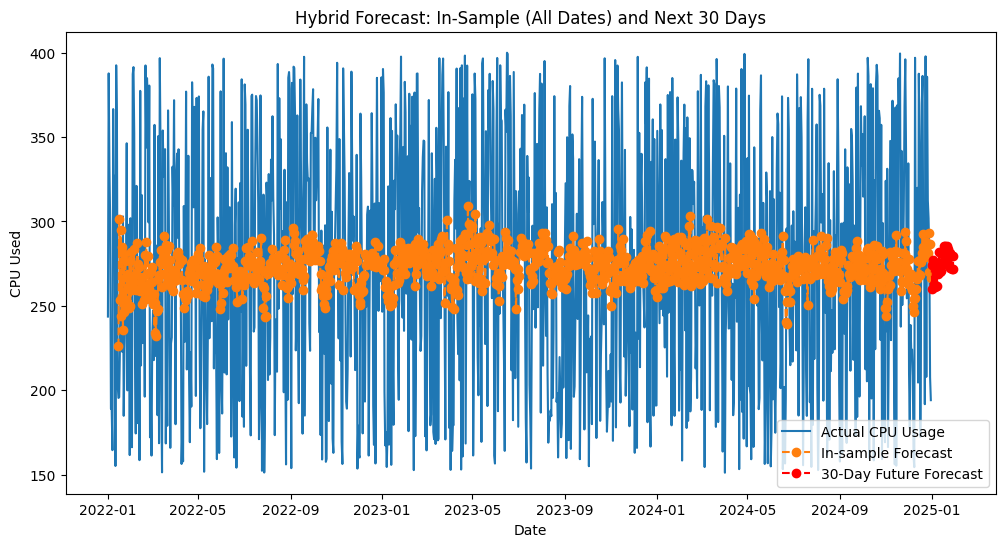

In [38]:
if __name__ == "__main__":
    global full_forecast_df
    full_forecast_df = main2()
    # main()

In [29]:
full_forecast_df.head()

,namespace,cpu_used,is_holiday,cpu_roll_mean_7,Forecast
2022-01-01,alpha,243.635030,1.0,243.635030,NaN
2022-01-02,alpha,387.678577,0.0,243.635030,NaN
2022-01-03,alpha,332.998485,0.0,315.656803,NaN
2022-01-04,alpha,299.664621,0.0,321.437364,NaN
2022-01-05,alpha,189.004660,0.0,315.994178,NaN


In [33]:
full_forecast_df.to_csv("../forecast/test1-simulated.csv", index=True)

In [30]:
full_forecast = full_forecast_df.dropna().copy()

In [39]:
mae, mape = compute_metrics(full_forecast['cpu_used'], full_forecast["Forecast"])
print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%")

MAE: 63.13, MAPE: 25.85%


In [32]:
full_forecast.tail(20)

,namespace,cpu_used,is_holiday,cpu_roll_mean_7,Forecast
2024-12-12,alpha,246.081662,0.0,231.879197,260.516337
2024-12-13,alpha,319.911821,0.0,235.346613,269.444763
2024-12-14,alpha,204.563472,0.0,249.037297,268.073218
2024-12-15,alpha,387.490296,0.0,248.488945,270.486023
2024-12-16,alpha,346.586254,0.0,280.912802,271.821135
2024-12-17,alpha,172.352751,0.0,308.358198,268.985407
2024-12-18,alpha,254.395194,0.0,276.275648,274.583068
2024-12-19,alpha,369.779577,0.0,275.911636,282.341963
2024-12-20,alpha,386.183006,0.0,293.582766,286.359646
2024-12-21,alpha,266.850378,0.0,303.050078,284.399872
